In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from artifact import Saw
from detector import WindowTransformerDetector

from data import TestArtifactDataset

/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)

In [9]:
test_width = 512

test_file = Path(f"../data/test_real_{test_width}.pkl")
start_index = 13100
final_index = 145355 # end of last annotated artifact

n = 130 # 13100 + 130*1024 = 146220
# test_file = Path(f"../data/test_real{test_width}.pkl")
# test_dataset = ["normalized_deviation_updated"]
if not test_file.exists():
    real_data_df = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/normalized_deviation_updated_TEST.pickle') 
    real_data = real_data_df[0]
    ground_truth = pd.read_csv('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/gt_realData.csv')
    test_ds = TestArtifactDataset.generate(
        start_index=start_index,
        labels=ground_truth,
        width=test_width,
        n=n,
        data=real_data,
        to=Path(f"../data/test_real_{test_width}.pkl"),
    )
else:
    test_ds = TestArtifactDataset(file=test_file)

In [10]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [11]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

first_detector = WindowTransformerDetector.load_from_checkpoint("../models/model.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_full_train", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=50000.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_full_simple_train", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_conv/", datastore_operation=ml_client.datastores)
convolution_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_conv/Checkpoint-model_name=0-validation=0.03.ckpt").cpu()


/opt/miniconda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.8, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


In [12]:
def baseline_detector(input: torch.Tensor) -> torch.Tensor:
    input.squeeze(0)

    prediction = torch.zeros(input.shape)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[1:] - input[:-1]).abs()
    mean_increment = torch.mean(increments)
    std_increment = torch.std(increments)
    mask = increments > mean_increment + 3*std_increment
    shaped_mask = torch.cat((mask, torch.Tensor([False]))).type(torch.bool)
    prediction[shaped_mask] = 1
    
    # flag highest/lowest point as artifact
    # or better also with mean/std?
    absolute_values = input.abs()
    max_index = torch.argmax(absolute_values)
    prediction[max_index-5 : max_index+5] = 1


    return prediction

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, roc_curve
import pandas as pd

metrics = pd.DataFrame(columns=['detector', 'accuracy', 'precision', 'recall', 'mse'])
index = 0

preds_base = list()
preds_cnn = list()
preds_trans = list()
gt = list()

threshold = 0.5

for sample in test_ds:
    example = sample["data"]
    stride  = 64
    window  = convolution_detector.window
    length  = len(example)

    example_data = torch.tensor(example)

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_conv = torch.zeros(((length - window) // stride + 1, length))
    predictions_trans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_conv[i, j : j + window] = convolution_detector(s.unsqueeze(0))
        predictions_trans[i, j : j + window] = transformer_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions_baseline = predictions_baseline.sum(axis=0) / masks
    preds_base = preds_base + predictions_baseline.tolist()
    predictions_baseline = np.where(predictions_baseline.numpy() > threshold, 1, 0)
    predictions_conv = predictions_conv.sum(axis=0) / masks
    preds_cnn = preds_cnn + predictions_conv.tolist()
    predictions_conv = np.where(predictions_conv.numpy() > threshold, 1, 0)
    predictions_trans = predictions_trans.sum(axis=0) / masks
    preds_trans = preds_trans + predictions_trans.tolist()
    predictions_trans = np.where(predictions_trans.numpy() > threshold, 1, 0)
    gt = gt + sample["mask"]['0'].tolist()

    tn_base, fp_base, fn_base, tp_base = confusion_matrix(sample["mask"], predictions_baseline, labels=[0, 1]).ravel()
    tn_conv, fp_conv, fn_conv, tp_conv = confusion_matrix(sample["mask"], predictions_conv, labels=[0, 1]).ravel()
    tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(sample["mask"], predictions_trans, labels=[0, 1]).ravel()

    new_row_baseline = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'baseline',
        'accuracy': accuracy_score(sample["mask"], predictions_baseline),
        'precision': precision_score(sample["mask"], predictions_baseline),
        'recall': recall_score(sample["mask"], predictions_baseline),
        'mse': mean_squared_error(sample["mask"], predictions_baseline), 
        'tn': tn_base,
        'fp': fp_base, 
        'fn': fn_base, 
        'tp': tp_base
    }])

    new_row_conv = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'cnn',
        'accuracy': accuracy_score(sample["mask"], predictions_conv),
        'precision': precision_score(sample["mask"], predictions_conv),
        'recall': recall_score(sample["mask"], predictions_conv),
        'mse': mean_squared_error(sample["mask"], predictions_conv),
        'tn': tn_conv,
        'fp': fp_conv, 
        'fn': fn_conv, 
        'tp': tp_conv
    }])

    new_row_trans = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'transformer',
        'accuracy': accuracy_score(sample["mask"], predictions_trans),
        'precision': precision_score(sample["mask"], predictions_trans),
        'recall': recall_score(sample["mask"], predictions_trans),
        'mse': mean_squared_error(sample["mask"], predictions_trans),
        'tn': tn_trans,
        'fp': fp_trans, 
        'fn': fn_trans, 
        'tp': tp_trans
    }])

    # preds_base = preds_base + predictions_baseline.tolist()
    # preds_cnn = preds_cnn + predictions_conv.tolist()
    # preds_trans = preds_trans + predictions_trans.tolist()
    # gt = gt + sample["mask"]['0'].tolist()

    metrics = pd.concat([metrics, new_row_baseline, new_row_conv, new_row_trans], ignore_index=True)
    index = index+1

/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-

In [11]:
freq_artifact = sum(gt)/(len(gt))
freq_artifact

0.02354266826923077

In [14]:
metrics_total = metrics.groupby('detector')[['accuracy', 'precision', 'recall', 'mse']].mean()
conf_mat_values = metrics.groupby('detector')[['tn', 'fp', 'fn', 'tp']].sum()

In [13]:
metrics_total

,accuracy,precision,recall,mse
detector,,,,
baseline,0.969516,0.203377,0.101864,0.030484
cnn,0.975826,0.194435,0.098524,0.024174
transformer,0.981295,0.312108,0.210371,0.018705


In [14]:
conf_mat_values = conf_mat_values.convert_dtypes()
conf_mat_values

,tn,fp,fn,tp
detector,,,,
baseline,128592,1394,2664,470
cnn,129296,690,2528,606
transformer,129300,686,1804,1330


In [15]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_base)
J = precision + recall
ix = np.argmax(J)
best_thresh_base = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_cnn)
J = precision + recall
ix = np.argmax(J)
best_thresh_cnn = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_trans)
J = precision + recall
ix = np.argmax(J)
best_thresh_trans = thresholds[ix]


In [16]:
from sklearn.metrics import fbeta_score

max_fbeta = 0
best_threshold = 0

for threshold in np.linspace(0,  1,  100):
    predictions_trans = np.where(preds_trans > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_trans, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold = threshold


In [17]:
best_threshold

0.5050505050505051

Text(0.5, 1.0, 'Validation Precision-Recall curve')

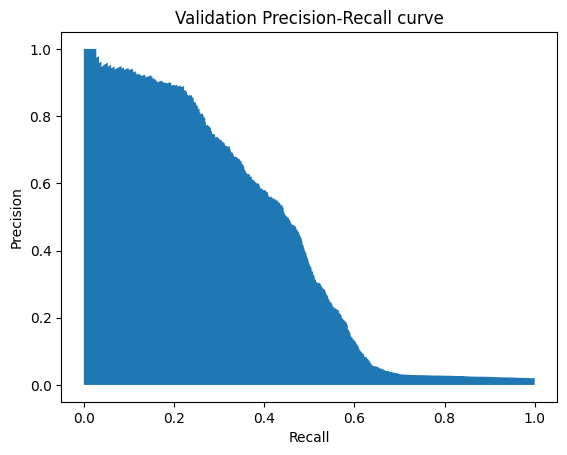

In [17]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

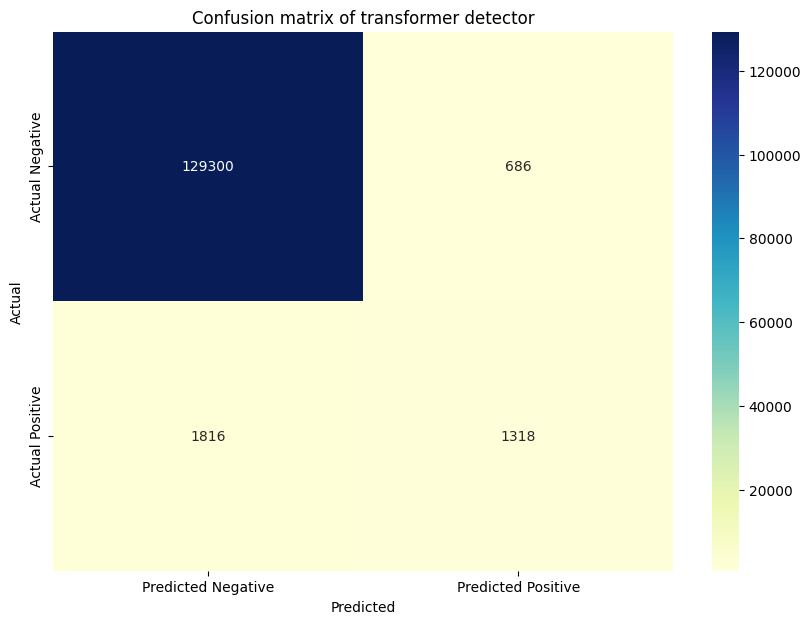

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

detector = 'transformer' # 'baseline', 'cnn', 'transformer'

# Construct the confusion matrix
# cm = np.array([[conf_mat_values.loc[conf_mat_values.detector == detector, 'tn'].iloc[0], conf_mat_values.loc[conf_mat_values.detector == detector, 'fp'].iloc[0]],
#                [conf_mat_values.loc[conf_mat_values.detector == detector, 'fn'].iloc[0], conf_mat_values.loc[conf_mat_values.detector == detector, 'tp'].iloc[0]]])

cm = np.array([[129300, 686],
               [1816, 1318]])

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",  xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative','Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion matrix of {detector} detector")
plt.show()

In [13]:
fpr, tpr, thresholds = roc_curve(gt, preds_base)
J = tpr - fpr
ix = np.argmax(J)
best_thresh_baseline = thresholds[ix]

fpr, tpr, thresholds = roc_curve(gt, preds_cnn)
J = tpr - fpr
ix = np.argmax(J)
best_thresh_cnn = thresholds[ix]

fpr, tpr, thresholds = roc_curve(gt, preds_trans)
J = tpr - fpr
ix = np.argmax(J)
best_thresh_trans = thresholds[ix]

In [19]:
metrics_transformer = metrics.query("detector == 'transformer'")

In [20]:
metrics_transformer.sort_values(by=["fp"], ascending=False).head(10)

,detector,accuracy,precision,recall,mse,index,start_index,tn,fp,fn,tp
269,transformer,0.837891,0.252747,0.190083,0.162109,89.0,104236.0,835.0,68.0,98.0,23.0
5,transformer,0.950195,0.000000,0.000000,0.049805,1.0,14124.0,973.0,51.0,0.0,0.0
386,transformer,0.890625,0.355263,0.300000,0.109375,128.0,144172.0,885.0,49.0,63.0,27.0
2,transformer,0.875977,0.100000,0.042105,0.124023,0.0,13100.0,893.0,36.0,91.0,4.0
242,transformer,0.964844,0.000000,0.000000,0.035156,80.0,95020.0,988.0,36.0,0.0,0.0
197,transformer,0.815430,0.128205,0.031250,0.184570,65.0,79660.0,830.0,34.0,155.0,5.0
38,transformer,0.971680,0.000000,0.000000,0.028320,12.0,25388.0,995.0,29.0,0.0,0.0
272,transformer,0.973633,0.315789,0.923077,0.026367,90.0,105260.0,985.0,26.0,1.0,12.0
302,transformer,0.940430,0.477273,0.355932,0.059570,100.0,115500.0,942.0,23.0,38.0,21.0
305,transformer,0.977539,0.000000,0.000000,0.022461,101.0,116524.0,1001.0,23.0,0.0,0.0


In [21]:
stats_index_fp = [89, 128, 1, 0, 65, 80, 12, 90, 101, 34]
stats_index_fn = [99, 123, 124, 128, 25]
stats_index_tp = [129, 116, 93, 5, 14]

In [ ]:
stats_benchmark_indices = [128, 1, 0, 65, 80, 99, 123, 124, 128, 25, 129, 116, 93, 5, 14]
stats_benchmark = [test_ds[index] for index in stats_benchmark_indices]
pickle.dump(stats_benchmark, open('../data/stats_benchmark.pkl', "wb"))

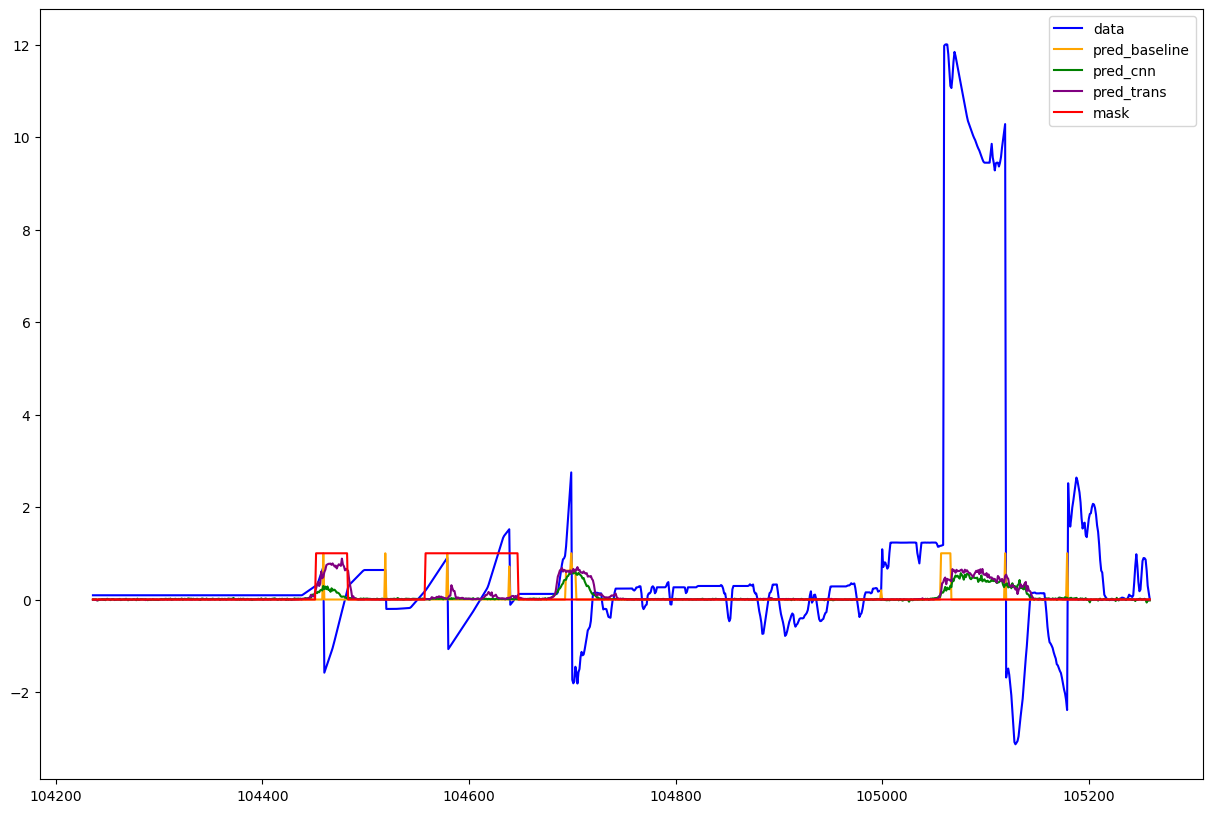

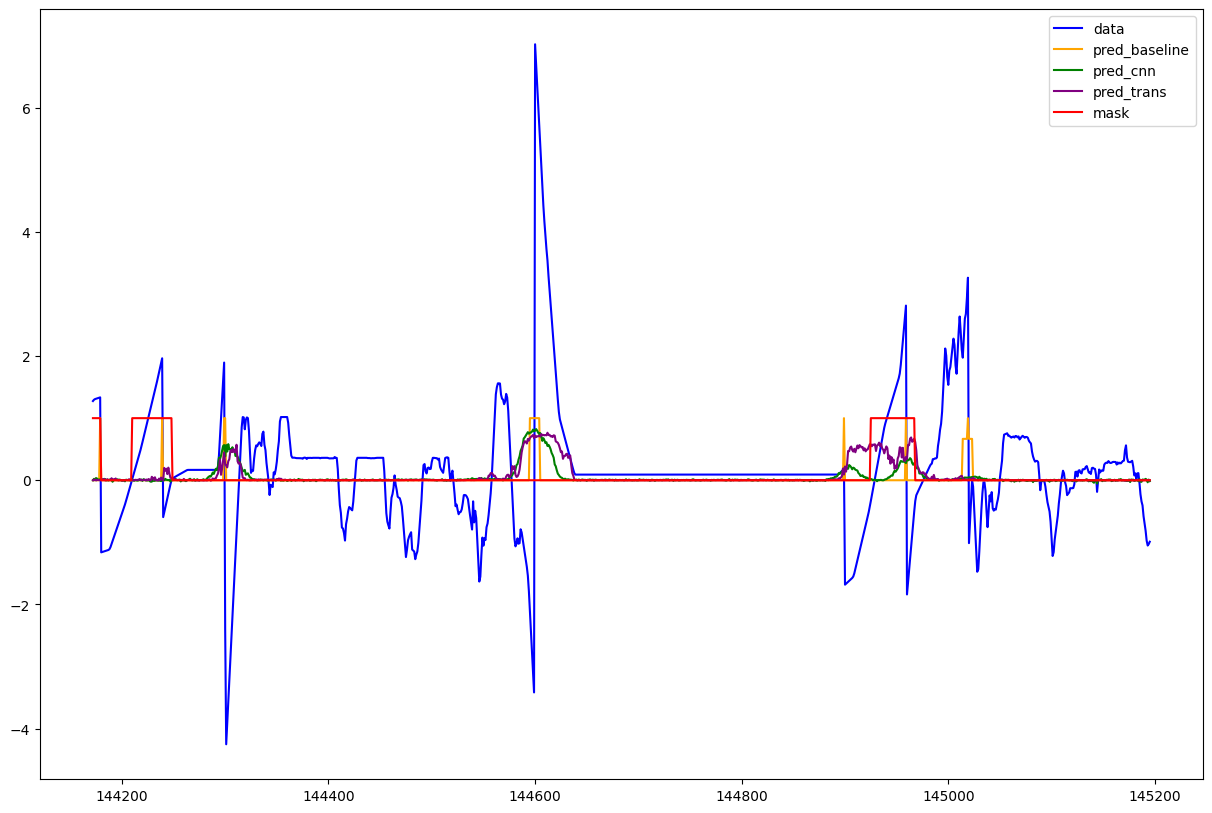

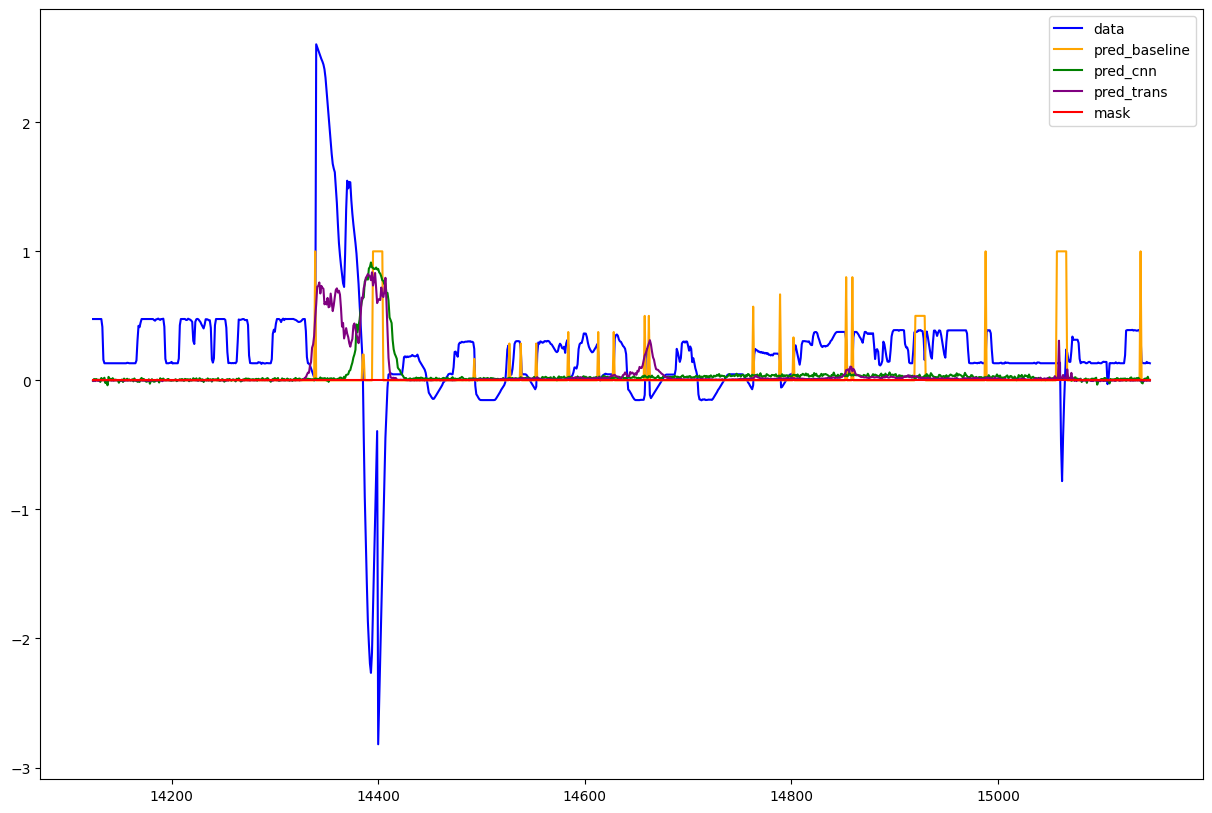

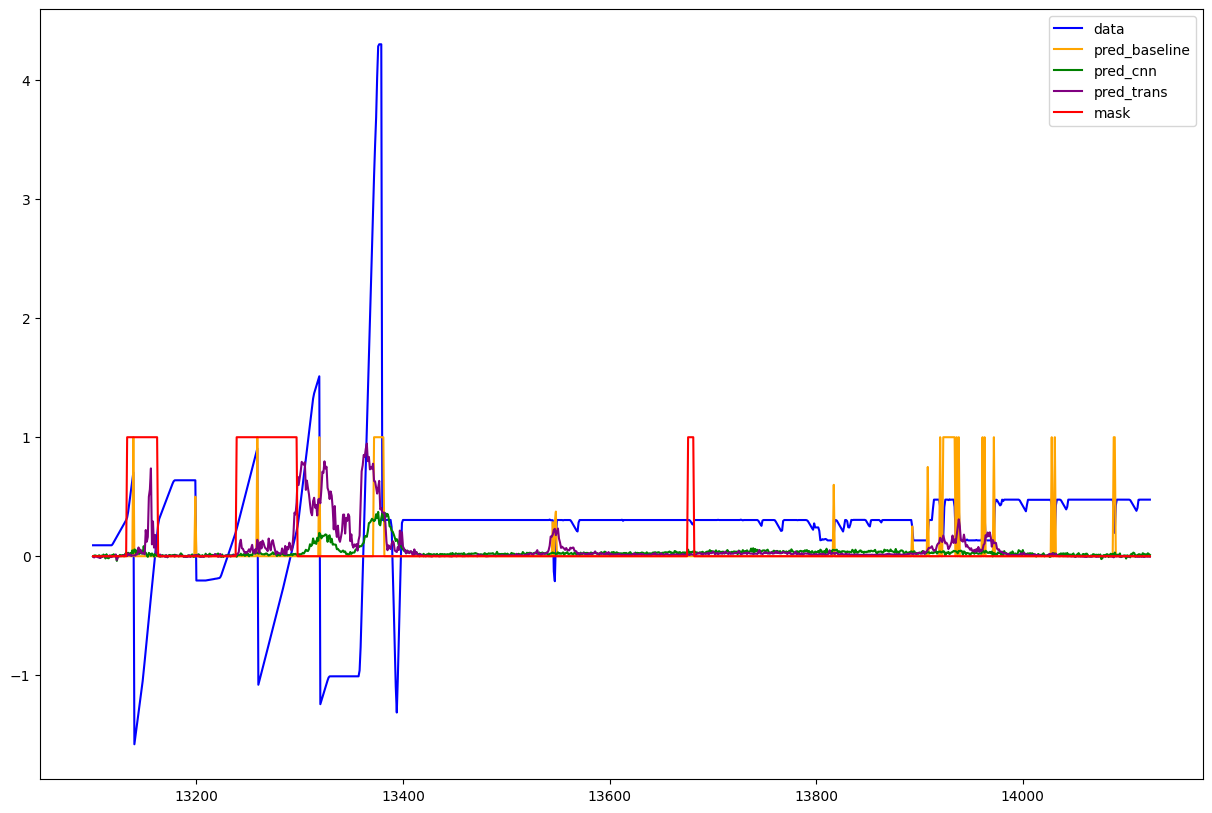

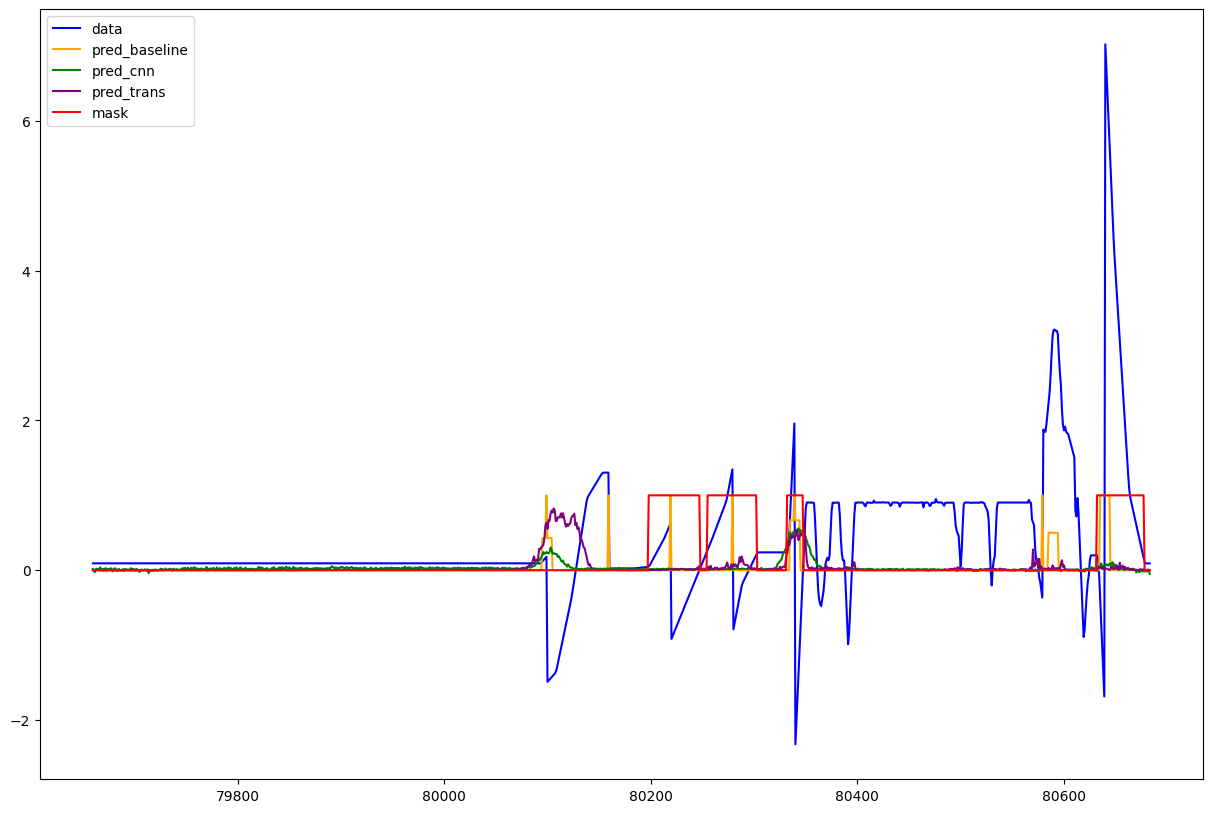

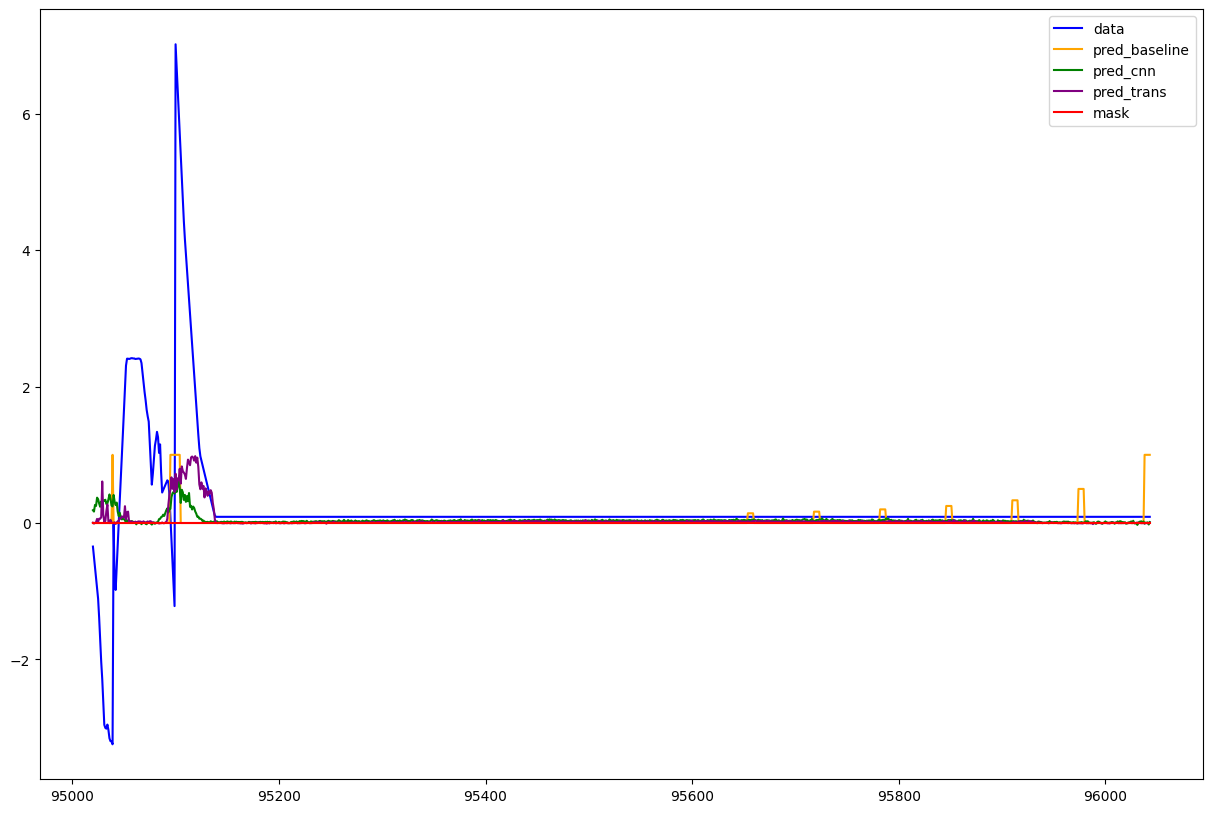

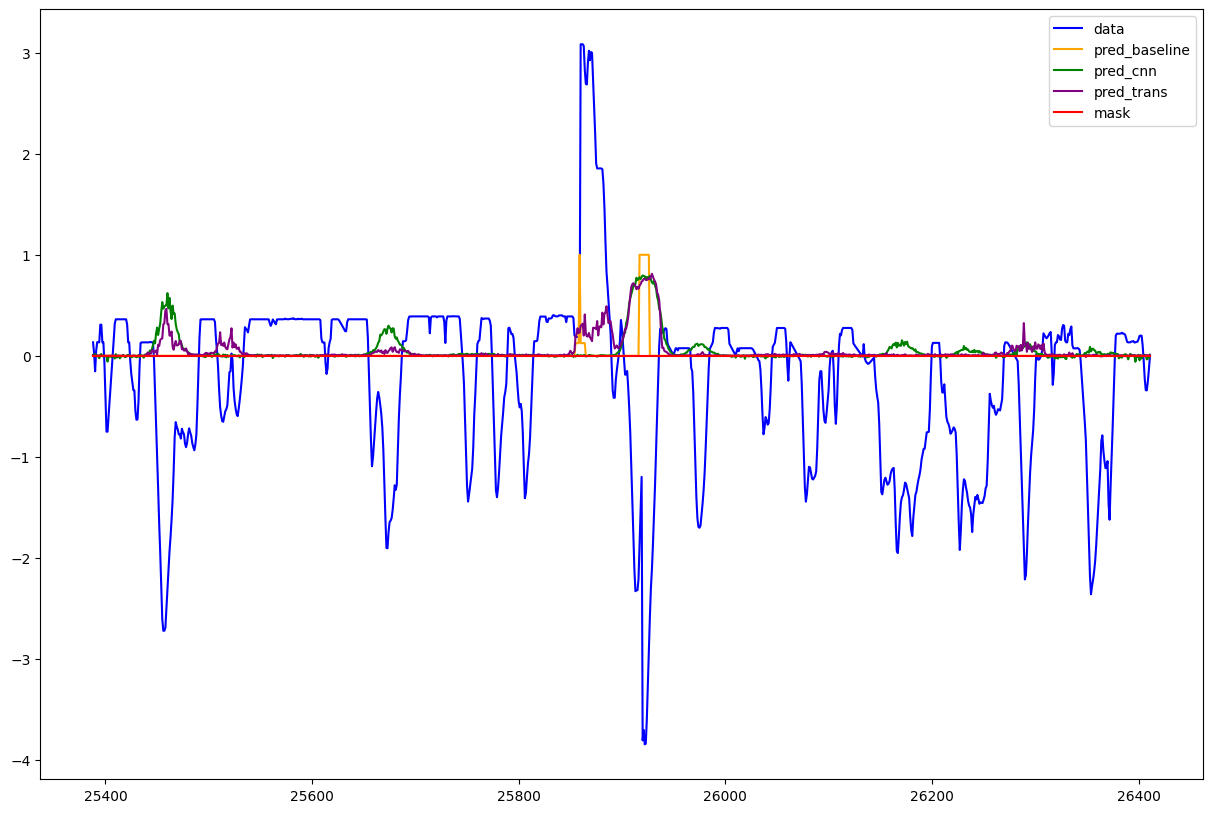

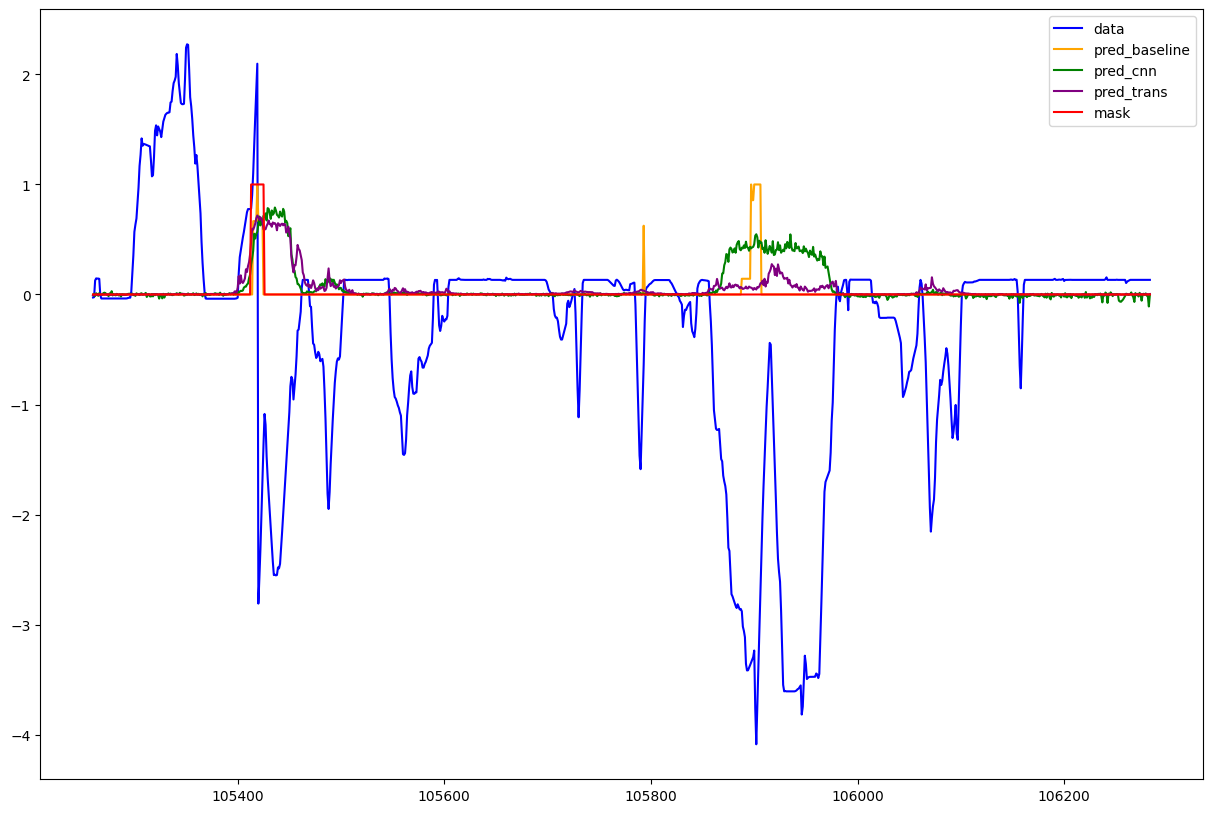

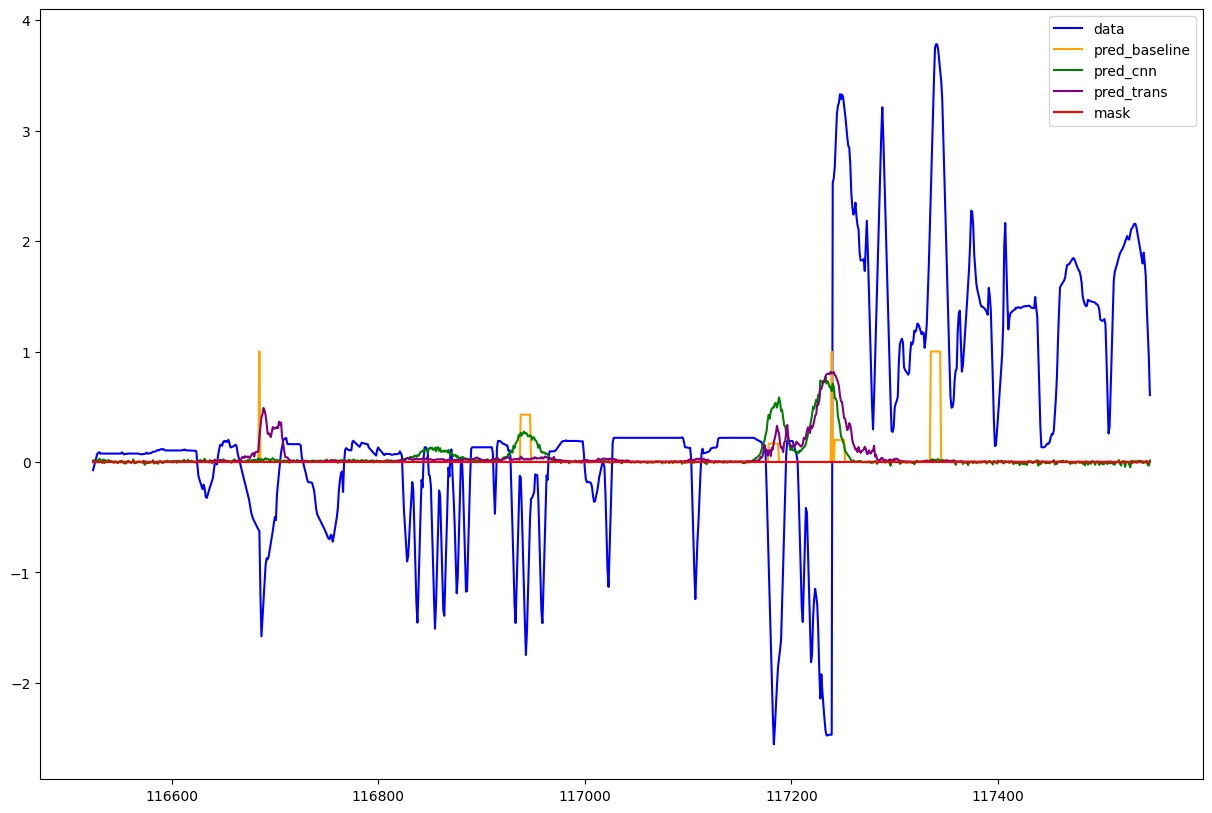

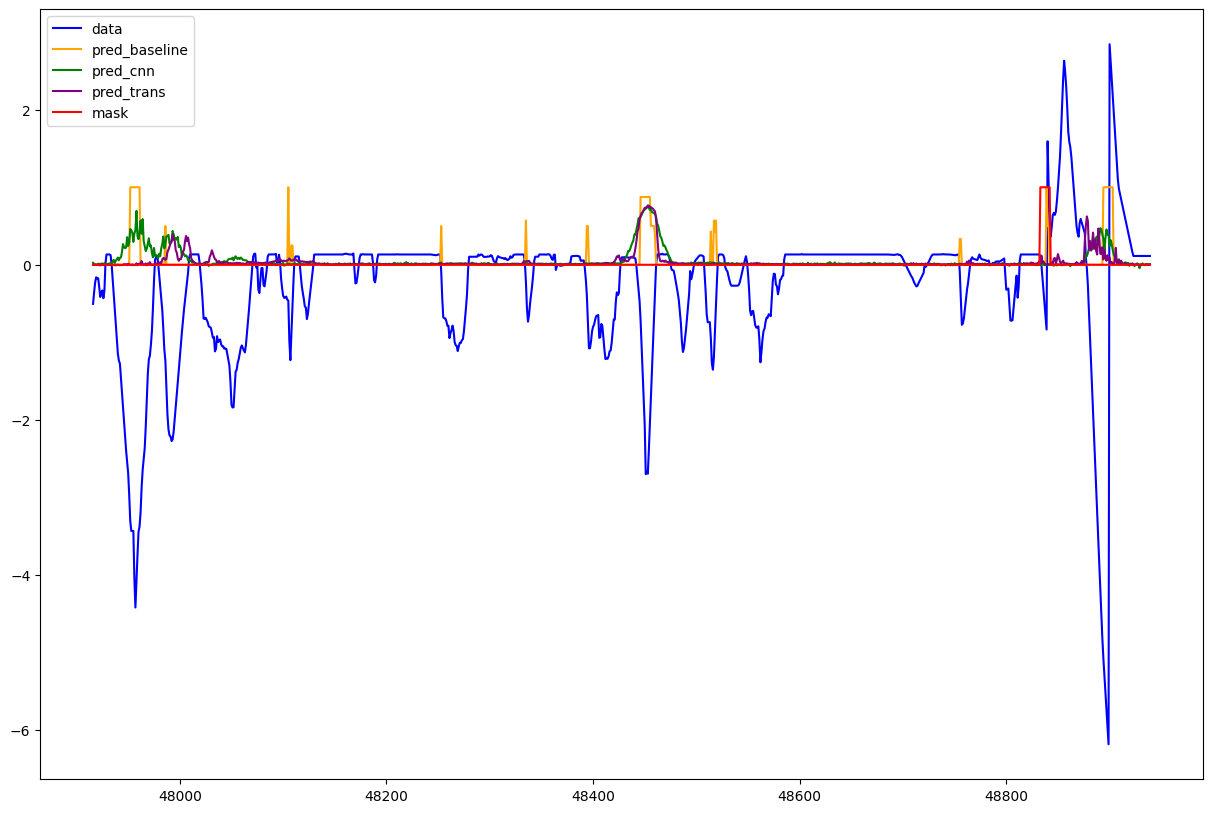

In [23]:
for index in stats_index_fp:
    sample = test_ds[index]

    example = sample["data"]
    stride  = 64
    window  = convolution_detector.window
    length  = len(example)

    example_data = torch.tensor(example)

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_conv = torch.zeros(((length - window) // stride + 1, length))
    predictions_trans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_conv[i, j : j + window] = convolution_detector(s.unsqueeze(0))
        predictions_trans[i, j : j + window] = transformer_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions_baseline = predictions_baseline.sum(axis=0) / masks
    predictions_conv = predictions_conv.sum(axis=0) / masks
    predictions_trans = predictions_trans.sum(axis=0) / masks
    # predictions_trans = np.where(predictions_trans.numpy() > threshold, 1, 0)

    plt.figure(figsize=(15, 10))
    plt.plot(sample["mask"].index, sample["data"], label="data", c="blue")
    plt.plot(sample["mask"].index, predictions_baseline, label="pred_baseline", c="orange")
    plt.plot(sample["mask"].index, predictions_conv, label="pred_cnn", c="green")
    plt.plot(sample["mask"].index, predictions_trans, label="pred_trans", c="purple")
    plt.plot(sample["mask"].index, sample["mask"], c="red", label="mask")
    #plt.title(f"Predictions of 3 models vs. ground truth in test set, sample {sample["start_index"]}")
    plt.legend()
    plt.show()